In [ ]:
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

from utils.loops import train_loop, eval_loop
from utils.lstm import LSTMRegressor
from utils.weather_dataset import WeatherDataset

random_state = 4
data_folder = '../resource/dataset'
batch_size = 32

# Load dataset

In [3]:
metadata = pd.read_csv(f'{data_folder}/metadata.csv')
metadata = metadata[metadata['attributes'] != 'weather_description']
city_coords = pd.read_csv(f'{data_folder}/raw/city_attributes.csv')

dfs = {
    attribute: pd.read_csv(f'{data_folder}/preprocessed/{attribute}.csv', index_col=0)
    for attribute in metadata['attributes']
}

city_coords = (city_coords
    .set_index('City')
    .loc[dfs['humidity']
    .columns][['Latitude', 'Longitude']]
)

dataset = WeatherDataset(7, city_coords, *dfs.values())

Train-test Split

In [4]:
train_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=.2, random_state=random_state
)
train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

# Load model

In [5]:
def run_epochs(
    epochs,
    model, loss_fn,
    optimizer,
    train_loader,
    test_loader,
    use_gpu: bool = False,
):
    loss = {
        'train': [],
        'eval': []
    }
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        train_loss = train_loop(
            model, loss_fn, optimizer, train_loader, use_gpu
        )
        print(f"  Train loss: {sum(train_loss) / len(train_loss):<.8f} || ", end='')

        eval_loss = eval_loop(
            model, loss_fn, test_loader, use_gpu
        )
        print(f"Eval loss: {sum(eval_loss) / len(eval_loss)}")

        loss['train'].append(train_loss)
        loss['eval'].append(eval_loss)

    return loss

In [6]:
train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True)

In [15]:
lstm_regressor = LSTMRegressor(
    dataset[0][0].shape[1],
    num_layers=4, hidden_size=512,
    fc_hidden_dims=(512, 512),
)
if torch.cuda.is_available():
    lstm_regressor.cuda()

mse_loss = torch.nn.MSELoss()
adam_opt = torch.optim.Adam(lstm_regressor.parameters(), 1e-5)

# Train loop

In [16]:
global_loss = {
    'train': [],
    'eval': []
}

In [22]:
loss = run_epochs(50,
    lstm_regressor, mse_loss,
    adam_opt, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

Epoch 0:


100%|██████████| 1692/1692 [00:17<00:00, 98.48it/s, Loss: 2949.937744140625] 


  Train loss: 636.36252527 || Eval loss: 765.0660775547614
Epoch 1:


100%|██████████| 1692/1692 [00:16<00:00, 100.24it/s, Loss: 771.7061767578125]


  Train loss: 638.05235300 || Eval loss: 705.6442851614445
Epoch 2:


100%|██████████| 1692/1692 [00:17<00:00, 96.89it/s, Loss: 2828.299072265625] 


  Train loss: 631.73314932 || Eval loss: 803.0047300803183
Epoch 3:


100%|██████████| 1692/1692 [00:16<00:00, 100.31it/s, Loss: 1072.1849365234375]


  Train loss: 658.99210932 || Eval loss: 674.3899691967254
Epoch 4:


100%|██████████| 1692/1692 [00:16<00:00, 99.66it/s, Loss: 695.0909423828125]


  Train loss: 628.75435530 || Eval loss: 833.0088401415669
Epoch 5:


100%|██████████| 1692/1692 [00:17<00:00, 98.50it/s, Loss: 2992.359130859375] 


  Train loss: 629.62409819 || Eval loss: 691.5140802910987
Epoch 6:


100%|██████████| 1692/1692 [00:16<00:00, 101.01it/s, Loss: 1326.6136474609375]


  Train loss: 630.75445367 || Eval loss: 670.3159794367797
Epoch 7:


100%|██████████| 1692/1692 [00:17<00:00, 95.18it/s, Loss: 469.2513122558594]


  Train loss: 624.04231172 || Eval loss: 720.7354858975602
Epoch 8:


100%|██████████| 1692/1692 [00:16<00:00, 100.12it/s, Loss: 234.0074920654297]


  Train loss: 624.28462853 || Eval loss: 792.5647790787068
Epoch 9:


100%|██████████| 1692/1692 [00:17<00:00, 99.38it/s, Loss: 737.0488891601562] 


  Train loss: 623.34079796 || Eval loss: 663.8560336498504
Epoch 10:


100%|██████████| 1692/1692 [00:17<00:00, 95.12it/s, Loss: 1068.6231689453125]


  Train loss: 622.85737971 || Eval loss: 668.9618581496795
Epoch 11:


100%|██████████| 1692/1692 [00:16<00:00, 100.40it/s, Loss: 1956.448486328125]


  Train loss: 623.59775266 || Eval loss: 956.9774315655936
Epoch 12:


100%|██████████| 1692/1692 [00:16<00:00, 99.83it/s, Loss: 544.4341430664062] 


  Train loss: 620.43433844 || Eval loss: 722.6875580050421
Epoch 13:


100%|██████████| 1692/1692 [00:17<00:00, 96.61it/s, Loss: 3932.06005859375] 


  Train loss: 619.17381184 || Eval loss: 749.457219405659
Epoch 14:


100%|██████████| 1692/1692 [00:16<00:00, 99.79it/s, Loss: 269.6816101074219] 


  Train loss: 617.66936352 || Eval loss: 703.9891490891189
Epoch 15:


100%|██████████| 1692/1692 [00:17<00:00, 98.32it/s, Loss: 1168.28759765625]


  Train loss: 613.42415135 || Eval loss: 655.977125091192
Epoch 16:


100%|██████████| 1692/1692 [00:17<00:00, 97.79it/s, Loss: 1215.849853515625] 


  Train loss: 614.14177734 || Eval loss: 795.2490545322427
Epoch 17:


100%|██████████| 1692/1692 [00:17<00:00, 99.51it/s, Loss: 1136.7706298828125] 


  Train loss: 613.58176312 || Eval loss: 847.5451035375572
Epoch 18:


100%|██████████| 1692/1692 [00:17<00:00, 96.33it/s, Loss: 396.9999694824219]


  Train loss: 610.77056520 || Eval loss: 728.4770839682144
Epoch 19:


100%|██████████| 1692/1692 [00:16<00:00, 99.74it/s, Loss: 1744.4932861328125] 


  Train loss: 609.82071192 || Eval loss: 686.7070889664598
Epoch 20:


100%|██████████| 1692/1692 [00:16<00:00, 99.62it/s, Loss: 3067.230224609375] 


  Train loss: 608.21644186 || Eval loss: 808.6085675467273
Epoch 21:


100%|██████████| 1692/1692 [00:17<00:00, 95.22it/s, Loss: 1320.95263671875] 


  Train loss: 608.78578540 || Eval loss: 789.5137202846806
Epoch 22:


100%|██████████| 1692/1692 [00:16<00:00, 99.83it/s, Loss: 942.5828247070312] 


  Train loss: 608.80419066 || Eval loss: 685.7416010286228
Epoch 23:


100%|██████████| 1692/1692 [00:16<00:00, 99.54it/s, Loss: 808.2499389648438] 


  Train loss: 605.59823125 || Eval loss: 658.6794893161061
Epoch 24:


100%|██████████| 1692/1692 [00:17<00:00, 96.38it/s, Loss: 367.7990417480469] 


  Train loss: 604.24195921 || Eval loss: 653.7082046977736
Epoch 25:


100%|██████████| 1692/1692 [00:17<00:00, 99.13it/s, Loss: 683.2915649414062] 


  Train loss: 604.14298168 || Eval loss: 727.1264280495069
Epoch 26:


100%|██████████| 1692/1692 [00:16<00:00, 99.70it/s, Loss: 2133.52783203125]


  Train loss: 603.83611336 || Eval loss: 892.1573398310524
Epoch 27:


100%|██████████| 1692/1692 [00:17<00:00, 99.42it/s, Loss: 528.4134521484375] 


  Train loss: 610.41287145 || Eval loss: 718.1153050055177
Epoch 28:


100%|██████████| 1692/1692 [00:16<00:00, 102.35it/s, Loss: 513.2990112304688]


  Train loss: 598.46351835 || Eval loss: 693.6231414578485
Epoch 29:


100%|██████████| 1692/1692 [00:16<00:00, 100.49it/s, Loss: 945.63037109375]


  Train loss: 597.21481329 || Eval loss: 676.842899331528
Epoch 30:


100%|██████████| 1692/1692 [00:16<00:00, 100.25it/s, Loss: 1030.4559326171875]


  Train loss: 598.68222630 || Eval loss: 726.6317492906647
Epoch 31:


100%|██████████| 1692/1692 [00:16<00:00, 101.84it/s, Loss: 1794.347412109375]


  Train loss: 597.83960119 || Eval loss: 720.4112431230839
Epoch 32:


100%|██████████| 1692/1692 [00:16<00:00, 100.39it/s, Loss: 454.6391296386719]


  Train loss: 595.03459688 || Eval loss: 718.8509243002457
Epoch 33:


100%|██████████| 1692/1692 [00:16<00:00, 100.93it/s, Loss: 867.8897705078125]


  Train loss: 594.31007193 || Eval loss: 638.206873972647
Epoch 34:


100%|██████████| 1692/1692 [00:16<00:00, 101.47it/s, Loss: 1043.9674072265625]


  Train loss: 591.51838909 || Eval loss: 724.3385318548685
Epoch 35:


100%|██████████| 1692/1692 [00:16<00:00, 99.55it/s, Loss: 1153.750732421875]


  Train loss: 592.17630469 || Eval loss: 811.694777901291
Epoch 36:


100%|██████████| 1692/1692 [00:16<00:00, 100.38it/s, Loss: 569.5783081054688]


  Train loss: 592.09493644 || Eval loss: 657.3175369875933
Epoch 37:


100%|██████████| 1692/1692 [00:16<00:00, 101.56it/s, Loss: 4304.283203125]


  Train loss: 590.67906604 || Eval loss: 754.2283994706246
Epoch 38:


100%|██████████| 1692/1692 [00:16<00:00, 99.74it/s, Loss: 1901.6024169921875]


  Train loss: 587.27063585 || Eval loss: 683.1513952521286
Epoch 39:


100%|██████████| 1692/1692 [00:16<00:00, 101.32it/s, Loss: 309.8557434082031]


  Train loss: 586.57209026 || Eval loss: 690.7086841772634
Epoch 40:


100%|██████████| 1692/1692 [00:16<00:00, 101.73it/s, Loss: 536.6900024414062]


  Train loss: 582.42036265 || Eval loss: 680.7044400695368
Epoch 41:


100%|██████████| 1692/1692 [00:17<00:00, 98.74it/s, Loss: 1462.030517578125]


  Train loss: 582.58240202 || Eval loss: 672.4643830283595
Epoch 42:


100%|██████████| 1692/1692 [00:16<00:00, 100.61it/s, Loss: 1694.006591796875]


  Train loss: 580.78484751 || Eval loss: 754.1791854389452
Epoch 43:


100%|██████████| 1692/1692 [00:16<00:00, 101.35it/s, Loss: 370.01904296875]


  Train loss: 578.26829702 || Eval loss: 633.081822388561
Epoch 44:


100%|██████████| 1692/1692 [00:17<00:00, 96.94it/s, Loss: 1057.8836669921875]


  Train loss: 577.63481370 || Eval loss: 639.6829182149107
Epoch 45:


100%|██████████| 1692/1692 [00:16<00:00, 100.88it/s, Loss: 939.4481811523438]


  Train loss: 578.82476439 || Eval loss: 617.1850047731513
Epoch 46:


100%|██████████| 1692/1692 [00:16<00:00, 101.84it/s, Loss: 426.98577880859375]


  Train loss: 574.04344205 || Eval loss: 710.5769027096724
Epoch 47:


100%|██████████| 1692/1692 [00:17<00:00, 96.95it/s, Loss: 2446.26123046875]


  Train loss: 572.83296670 || Eval loss: 779.071048817736
Epoch 48:


100%|██████████| 1692/1692 [00:16<00:00, 100.95it/s, Loss: 363.7228698730469]


  Train loss: 574.30434812 || Eval loss: 683.3785554782155
Epoch 49:


100%|██████████| 1692/1692 [00:16<00:00, 100.89it/s, Loss: 1282.338623046875]


  Train loss: 568.45258664 || Eval loss: 744.5313390276392


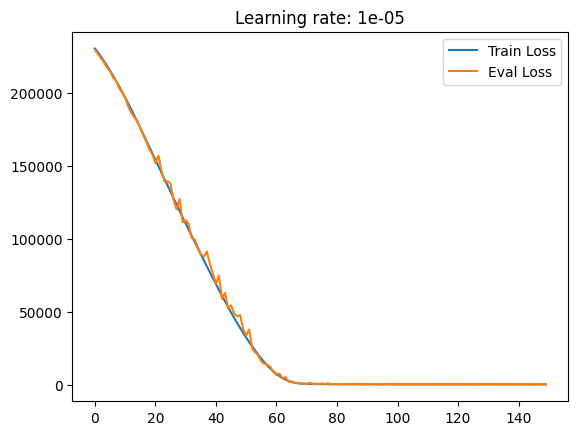

In [23]:
import matplotlib.pyplot as plt

plt.title(f"Learning rate: {1e-5}")
plt.plot([sum(loss) / len(loss) for loss in global_loss['train']], label='Train Loss')
plt.plot([sum(loss) / len(loss) for loss in global_loss['eval']], label='Eval Loss')
plt.legend();

In [ ]:
checkpoint = {
    'model': lstm_regressor.state_dict(),
    'optimizer': adam_opt.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../resource/models/lstm_4layer_with_mlp_cp2.tar')